---
# Recommendation System
Content Based Filtering

<p> https://www.kaggle.com/code/ibtesama/getting-started-with-a-movie-recommendation-system#Content-Based-Filtering </p>
---

### Import Dataset

In [1]:
import pandas as pd
import numpy as np

In [2]:
df1 = pd.read_csv("dataset/tmdb_5000_credits.csv")
df2 = pd.read_csv("dataset/tmdb_5000_movies.csv")


<p> The first dataset contains the following features:-

movie_id - A unique identifier for each movie.
cast - The name of lead and supporting actors.
crew - The name of Director, Editor, Composer, Writer etc.
The second dataset has the following features:-

budget - The budget in which the movie was made.
genre - The genre of the movie, Action, Comedy ,Thriller etc.
homepage - A link to the homepage of the movie.
id - This is infact the movie_id as in the first dataset.
keywords - The keywords or tags related to the movie.
original_language - The language in which the movie was made.
original_title - The title of the movie before translation or adaptation.
overview - A brief description of the movie.
popularity - A numeric quantity specifying the movie popularity.
production_companies - The production house of the movie.
production_countries - The country in which it was produced.
release_date - The date on which it was released.
revenue - The worldwide revenue generated by the movie.
runtime - The running time of the movie in minutes.
status - "Released" or "Rumored".
tagline - Movie's tagline.
title - Title of the movie.
vote_average - average ratings the movie recieved.
vote_count - the count of votes recieved.
Let's join the two dataset on the 'id' column</p>

In [3]:
print(df1.head(10))

   movie_id                                     title  \
0     19995                                    Avatar   
1       285  Pirates of the Caribbean: At World's End   
2    206647                                   Spectre   
3     49026                     The Dark Knight Rises   
4     49529                               John Carter   
5       559                              Spider-Man 3   
6     38757                                   Tangled   
7     99861                   Avengers: Age of Ultron   
8       767    Harry Potter and the Half-Blood Prince   
9    209112        Batman v Superman: Dawn of Justice   

                                                cast  \
0  [{"cast_id": 242, "character": "Jake Sully", "...   
1  [{"cast_id": 4, "character": "Captain Jack Spa...   
2  [{"cast_id": 1, "character": "James Bond", "cr...   
3  [{"cast_id": 2, "character": "Bruce Wayne / Ba...   
4  [{"cast_id": 5, "character": "John Carter", "c...   
5  [{"cast_id": 30, "character": "Pe

In [4]:
df1.columns = ['id' , 'tittle' , 'cast' , 'crew']
df2 = df2.merge(df1, on='id')

## 1. Demographic Filtering

In [5]:
C = df2['vote_average'].mean() # Mean vote across whole report
C

6.092171559442011

In [6]:
m = df2['vote_count'].quantile(0.9)
m # minimum votes required

1838.4000000000015

In [7]:
q_movies = df2.copy().loc[df2['vote_count'] >= m]
q_movies.shape # qualified movies 

(481, 23)

In [8]:
def weighted_rating(x , m = m , C = C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on IMDB Formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [9]:
# create new column "score" with created function above
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)

In [10]:
# Sort by new "SCORE"
q_movies = q_movies.sort_values('score' , ascending=False)

# Show top 10
q_movies[['title' , 'vote_count' , 'vote_average' , 'score']].head(10)

,title,vote_count,vote_average,score
1881,The Shawshank Redemption,8205,8.5,8.059258
662,Fight Club,9413,8.3,7.939256
65,The Dark Knight,12002,8.2,7.920020
3232,Pulp Fiction,8428,8.3,7.904645
96,Inception,13752,8.1,7.863239
3337,The Godfather,5893,8.4,7.851236
95,Interstellar,10867,8.1,7.809479
809,Forrest Gump,7927,8.2,7.803188
329,The Lord of the Rings: The Return of the King,8064,8.1,7.727243
1990,The Empire Strikes Back,5879,8.2,7.697884


### Now we created a <b> Trending Now </b> 

Text(0.5, 1.0, 'Trending Movies')

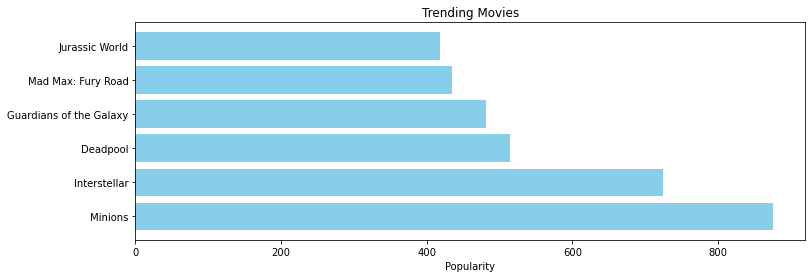

In [11]:
pop = df2.sort_values('popularity' , ascending=False)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))

plt.barh(pop['title'].head(6) , pop['popularity'].head(6), align='center' , color='skyblue')
plt.gca().invert_xaxis
plt.xlabel("Popularity")
plt.title("Trending Movies")

## 2. Content Based Filtering

In [12]:
df2['overview'].head(5)

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
3    Following the death of District Attorney Harve...
4    John Carter is a war-weary, former military ca...
Name: overview, dtype: object

In [13]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
df2['overview'] = df2['overview'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df2['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

# 20,000 different words were used to describe the 4800 movies in our dataset.

(4803, 20978)

In [14]:
# Compute Similarity Score

# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [15]:
#Construct a reverse map of indices and movie titles

indices = pd.Series(df2.index, index=df2['title']).drop_duplicates()

### get_recommendation() function

In [16]:
# Function that takes in movie title as input and outputs most similar movies

def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df2['title'].iloc[movie_indices]

In [17]:
get_recommendations('The Dark Knight Rises')

65                              The Dark Knight
299                              Batman Forever
428                              Batman Returns
1359                                     Batman
3854    Batman: The Dark Knight Returns, Part 2
119                               Batman Begins
2507                                  Slow Burn
9            Batman v Superman: Dawn of Justice
1181                                        JFK
210                              Batman & Robin
Name: title, dtype: object

In [18]:
get_recommendations('The Avengers')

7               Avengers: Age of Ultron
3144                            Plastic
1715                            Timecop
4124                 This Thing of Ours
3311              Thank You for Smoking
3033                      The Corruptor
588     Wall Street: Money Never Sleeps
2136         Team America: World Police
1468                       The Fountain
1286                        Snowpiercer
Name: title, dtype: object

### Improve recommendation system by considering [ credits , genre's , actors ]|

In [19]:
# Parse the stringified features into their corresponding python objects
from ast import literal_eval

features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    df2[feature] = df2[feature].apply(literal_eval)

In [20]:
# Get the director's name from the crew feature. If director is not listed, return NaN
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [21]:
# Returns the list top 3 elements or entire list; whichever is more.
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []

In [22]:
# Define new director, cast, genres and keywords features that are in a suitable form.
df2['director'] = df2['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    df2[feature] = df2[feature].apply(get_list)

In [23]:
# Print the new features of the first 3 films
df2[['title', 'cast', 'director', 'keywords', 'genres']].head(3)

,title,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski,"[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes,"[spy, based on novel, secret agent]","[Action, Adventure, Crime]"


In [24]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [25]:
# Apply clean_data function to your features.
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    df2[feature] = df2[feature].apply(clean_data)

In [26]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])
df2['soup'] = df2.apply(create_soup, axis=1)

In [27]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df2['soup'])

In [28]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [29]:
# Reset index of our main DataFrame and construct reverse mapping as before
df2 = df2.reset_index()
indices = pd.Series(df2.index, index=df2['title'])

In [30]:
### use get_recommendation() function with osine_sim2 as 2nd argument

In [31]:
get_recommendations('The Dark Knight Rises', cosine_sim2)

65               The Dark Knight
119                Batman Begins
4638    Amidst the Devil's Wings
1196                The Prestige
3073           Romeo Is Bleeding
3326              Black November
1503                      Takers
1986                      Faster
303                     Catwoman
747               Gangster Squad
Name: title, dtype: object

In [32]:
get_recommendations('The Godfather', cosine_sim2)

867      The Godfather: Part III
2731      The Godfather: Part II
4638    Amidst the Devil's Wings
2649           The Son of No One
1525              Apocalypse Now
1018             The Cotton Club
1170     The Talented Mr. Ripley
1209               The Rainmaker
1394               Donnie Brasco
1850                    Scarface
Name: title, dtype: object

In [33]:
get_recommendations('Scarface', cosine_sim2)

4638    Amidst the Devil's Wings
2240         A Most Violent Year
2543                    Cop Land
2609                   Dark Blue
1792                 Pain & Gain
2649           The Son of No One
2932                Raising Cain
3326              Black November
1503                      Takers
1986                      Faster
Name: title, dtype: object

## 3. Collaborative Filtering

In [1]:
!pip install scikit-surprise

You should consider upgrading via the 'E:\Programming_Files\Python\python.exe -m pip install --upgrade pip' command.


In [2]:
from surprise import Reader, Dataset, SVD, evaluate
reader = Reader()
ratings = pd.read_csv('../input/the-movies-dataset/ratings_small.csv')
ratings.head()

ModuleNotFoundError: No module named 'surprise'